In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="7" #この数字がpytorchから見えるgpuの番号

In [2]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

#SSD300の設定
ssd_cfg = {
    'num_classes':21, 
    'input_size':300, 
    'bbox_aspect_num':[4,6,6,6,4,4], 
    'feature_maps':[38, 19, 10, 5, 3, 1], #各sourceの画像サイズ
    'steps':[8,16,32,64,100,300], #DBOXの大きさを決める
    'min_sizes':[30,60,111,162,213,264], #DBOXの大きさを決める
    'max_sizes':[60,111,162,213,264,315], #DBOXの大きさを決める
    'aspect_ratios':[[2],[2,3],[2,3],[2,3],[2],[2]],
}

#SSDネットワークモデル
net = SSD(phase='inference', cfg=ssd_cfg)

#SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_50.pth', map_location={'cuda:0':'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


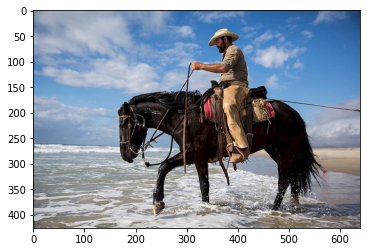

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0170, 0.0170, 0.5813, 0.1021, 0.6292],
          [0.0108, 0.4098, 0.1380, 0.5470, 0.3155],
          [0.0101, 0.9261, 0.3807, 1.0023, 0.4847],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0675, 0.7340, 0.6864, 0.8714, 0.9046],
          [0.0579, 0.7647, 0.8403, 0.8536, 0.9329],
          [0.0529, 0.2886, 0.2907, 0.8699, 0.9110],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [3]:
from utils.ssd_model import DataTransform

#1. 画像読み込み
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)
height, width, channels = img.shape

#2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#3. 前処理クラスの作成
color_mean = (104, 117, 123) 
input_size = 300
transform = DataTransform(input_size, color_mean)

#4. 前処理
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, "", "") #アノテーションはないので""にする
img = torch.from_numpy(img_transformed[:,:,(2,1,0)]).permute(2,0,1)

#5. SSDで予測
net.eval()
x = img.unsqueeze(0) #ミニバッチ化:torch.Size([1,3,300,300])
detections = net(x)

print(detections.shape)
print(detections)

#output:torch.Size([batch_num, 21, 200, 5])
# = (batch_num, クラス，confのtop200, 規格化されたbboxの情報)
# 規格化されたBBoxの情報(確信度，xmin, ymin, xmax, yamx)

/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


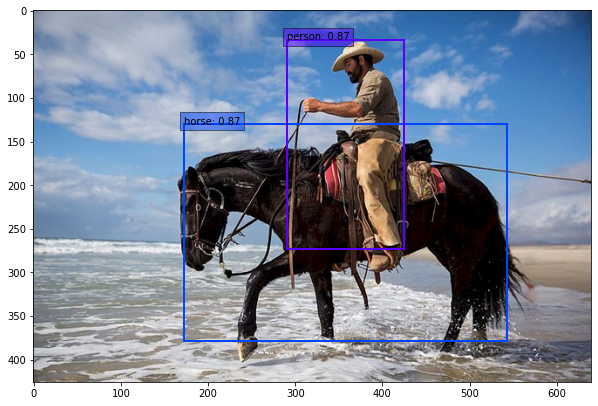

In [4]:
#画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

#ファイルパス
image_file_path = "./data/cowboy-757575_640.jpg"

#予測と，予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)